In [63]:
import pandas as pd
import helper
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [102]:
idx_cols = ['subj_id', 'tta_condition', 'd_condition']

exp_data = pd.read_csv('../data/measures.csv')
model_params_path = '../model_fit_results/cross_validation_or_merged.csv'
model_measures_path = '../model_fit_results/cross_validation_or_measures.csv'
model_params = pd.read_csv(model_params_path).rename(columns={'tta': 'tta_condition', 'd': 'd_condition'})
model_params = model_params.set_index(['subj_id', 'tta_condition', 'd_condition'])
model_measures = pd.read_csv(model_measures_path)
model_measures = model_measures.join(model_params['loss'], on=idx_cols)
get_turn_count = lambda g: len(g[g.is_turn_decision])
counts = pd.DataFrame(exp_data.groupby(idx_cols).apply(get_turn_count).rename('test_set_size'))
counts = counts.join(exp_data.groupby('subj_id').apply(get_turn_count).rename('overall_size'))
counts['train_set_size'] = counts.overall_size - counts.test_set_size
model_measures = model_measures.join(counts['train_set_size'], on=idx_cols)

p_turn_exp = exp_data.groupby(['subj_id', 'tta_condition', 'd_condition']).is_turn_decision.mean().rename('p_turn_exp')
model_measures = model_measures.join(p_turn_exp, on=idx_cols)
model_measures['p_diff'] = 4*(model_measures.p_turn_exp - model_measures.is_turn_decision)**2

In [78]:
model_measures.nlargest(5, 'p_diff')

,tta_condition,d_condition,is_turn_decision,RT,subj_id,loss,p_turn_exp,size,p_diff
35,6.0,120.0,9.315397e-07,0.608653,616.0,0.343585,0.461538,13,0.852068
62,6.0,120.0,9.368423e-01,0.573981,755.0,0.303596,0.500000,8,0.763325
54,4.0,90.0,3.464710e-01,0.467259,755.0,0.388123,0.000000,11,0.480169
17,6.0,120.0,8.214557e-01,0.806821,389.0,0.186953,0.538462,13,0.320343
52,6.0,150.0,9.709788e-01,0.730574,642.0,0.251704,0.692308,13,0.310630


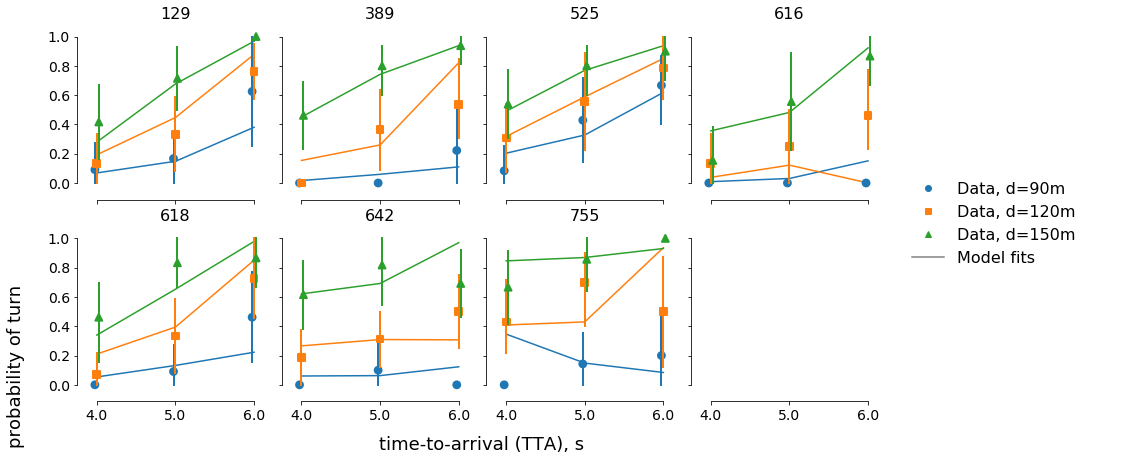

In [39]:
helper.plot_var_by_subject_v2(data=exp_data, model_measures_path=model_measures_path, 
                              var='is_turn_decision', ylabel='probability of turn');

It seems like the discrepancies on the probability plot are not reflected in loss function values. Is there a correlation between them at all?

In [68]:
np.corrcoef(model_measures.loss, model_measures.p_diff)

array([[ 1.        , -0.06969184],
       [-0.06969184,  1.        ]])

In [69]:
np.corrcoef(model_measures[model_measures.p_diff<0.4].loss, model_measures[model_measures.p_diff<0.4].p_diff)

array([[ 1.        , -0.15710782],
       [-0.15710782,  1.        ]])

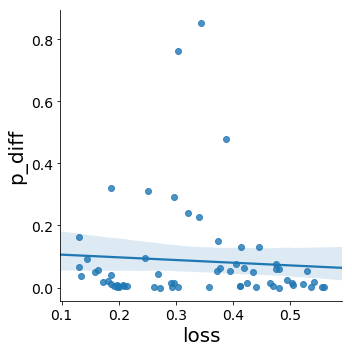

In [66]:
sns.lmplot(data=model_measures, x='loss', y='p_diff')

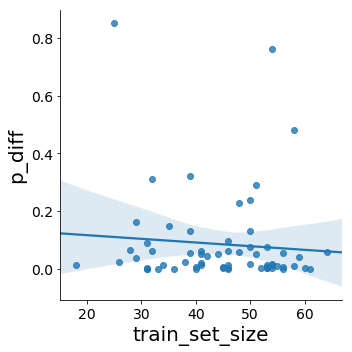

In [104]:
sns.lmplot(data=model_measures, x='train_set_size', y='p_diff')

For three conditions, p_diff is really different from loss. Let's run fitting for these three conditions multiple times and see if the found best-fit params are robust